In [217]:
import pandas as pd
import numpy as np
import os, pickle
import json
data1=[]
rootdir = 'T20_matches'
cnt=0
for subdir, dirs, files in os.walk(rootdir):
    # print(dirs)
    # if(cnt>=50):
    #     break
    try: 
        for file in files:
            # print(cnt)
            if(file[-1]=='v'):
                continue
            # if(cnt>=50):
            #     break
            if file.endswith('1.pkl'):
                # print(os.path.join(subdir,"match_info.json"))
                # print(cnt)
                with open(os.path.join(subdir,file), 'rb') as f:
                    # print("here")
                    data1 = (pickle.load(f))
                    with open(os.path.join(subdir,"match_info.json")) as file:
                        match_info = json.load(file)
                        # print("here")
                    if cnt==0:
                        df1 = pd.DataFrame(data1,columns=['bowler', 'batsman', 'wickets', 'over', 'outcome'])
                        df1['batting_team'] = match_info['First Innings']
                        df1['bowling_team'] = match_info['Second Innings']
                        df1['venue'] = match_info['Stadium Name']
                        df1['toss_won'] = int(match_info['Toss Winner'] == match_info['First Innings'])
                        df1['runs'] = df1['outcome'].apply(custom_sum).cumsum() 
                        df1['runs'][1:]=df1['runs'][:-1]
                        df1['runs'][0]=0 
                        # df1['batsmanRuns'] = [{} for _ in range(len(df1))]
                        for i in range(8):
                            df1[f"{i}"] = int(0)
                        # df1['current_batsman_runs'] = [0 for _ in range(len(df1))]
                        # df1 =  df1.apply(strikeratedict,axis=1)
                        # df1 =  df1.apply(strikerate,axis=1)
                        
                        runs_dict = {}
                        stat_dict = {}
                        # Define a custom function to update the runs for the current batsman
                        def update_runs(row):
                            global runs_dict
                            batsman = row['batsman']
                            outcome = int(row['outcome'])
                            runs = runs_dict.get(batsman, 0)  # Get the current runs for the batsman (default is 0)
                            if outcome in [0,1,2,3,4,6]:  # Update runs based on the outcome
                                runs_dict[batsman] = runs + outcome
                                # print(runs1)
                            # runs_dict[batsman] = runs1  # Update runs for the batsman in the dictionary
                            return runs
                        def update_stat(row):
                            global stat_dict
                            batsman = row['batsman']
                            outcome = int(row['outcome'])
                            if batsman not in stat_dict:
                                stat_dict[batsman] = np.zeros(8)
                            
                            # stat = stat_dict.get(batsman, np.zeros(8))
                            stat = stat_dict[batsman]
                            for i in range(8):
                                row[f"{i}"] = stat[i]
                            # row[f"{outcome}"] = stat[outcome]
                            stat[outcome] = stat[outcome] + 1
                            stat_dict[batsman] = stat
                            # row[f"{outcome}"] = row[f"{outcome}"] + 1
                            return row
                        
                        df1['curr_bats_Runs'] = df1.apply(update_runs, axis=1)
                        df1 = df1.apply(update_stat, axis=1)
                        # print("df1.head()")
                    else:
                        dft = pd.DataFrame(data1,columns=['bowler', 'batsman', 'wickets', 'over', 'outcome'])
                        dft['batting_team'] = match_info['First Innings']
                        dft['bowling_team'] = match_info['Second Innings']
                        dft['venue'] = match_info['Stadium Name']
                        dft['toss_won'] = int(match_info['Toss Winner'] == match_info['First Innings'])
                        dft['runs'] = dft['outcome'].apply(custom_sum).cumsum() 
                        dft['runs'][1:]=dft['runs'][:-1]
                        dft['runs'][0]=0
                        # dft['batsmanRuns'] = [{} for _ in range(len(dft))]
                        # dft['current_batsman_runs'] = [0 for _ in range(len(dft))]
                        # dft =  dft.apply(strikeratedict,axis=1)
                        # dft =  dft.apply(strikerate,axis=1)
                        
                        runs_dict = {}

                        # Define a custom function to update the runs for the current batsman
                        def update_runs(row):
                            global runs_dict
                            batsman = row['batsman']
                            outcome = int(row['outcome'])
                            runs = runs_dict.get(batsman, 0)  # Get the current runs for the batsman (default is 0)
                            if outcome in [0,1,2,3,4,6]:  # Update runs based on the outcome
                                runs_dict[batsman] = runs + outcome
                            # runs_dict[batsman] = runs1  # Update runs for the batsman in the dictionary
                            return runs
                        def update_stat(row):
                            global stat_dict
                            batsman = row['batsman']
                            outcome = int(row['outcome'])
                            if batsman not in stat_dict:
                                stat_dict[batsman] = np.zeros(8)
                            # stat = stat_dict.get(batsman, np.zeros(8))
                            stat = stat_dict[batsman]
                            for i in range(8):
                                row[f"{i}"] = stat[i]
                            # row[f"{outcome}"] = stat[outcome]
                            stat[outcome] = stat[outcome] + 1
                            stat_dict[batsman] = stat
                            # row[f"{outcome}"] = row[f"{outcome}"] + 1
                            return row
                        dft['curr_bats_Runs'] = dft.apply(update_runs, axis=1)
                        for i in range(8):
                            dft[f"{i}"] = int(0)
                        dft = dft.apply(update_stat, axis=1)
                        df1 = pd.concat([df1,dft],ignore_index=True)



                    cnt+=1
                    
    except: 
        pass

/var/folders/lz/7tzrmr9x1xs5pplr6wnzp5jr0000gn/T/ipykernel_1109/3263903193.py:35: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df1['runs'][1:]=df1['runs'][:-1]
/var/folders/lz/7tzrmr9x1xs5pplr6wnzp5jr0000gn/T/ipykernel_1109/3263903193.py:35

In [130]:
def custom_sum(x):
  """
  This function checks if the value is in the skip list and returns 0 if it is.
  Otherwise, it returns the value itself.
  """
  skip_values = [5, 7]  # Values to exclude from cumulative sum
  if x in skip_values:
    return 0
  else:
    return x

def strikeratedict(x):
  if x['batsman'] in x['batsmanRuns']:
    x['batsmanRuns'][x['batsman']]+=x['runs']
  else:
    x['batsmanRuns'][x['batsman']]=x['runs']
  return x

def strikerate(x):
  if(x['outcome'] in [5,7]):
    x['current_batsman_runs'] = x['batsmanRuns'][x['batsman']]
  else:
    x['current_batsman_runs'] = x['batsmanRuns'][x['batsman']]- x['outcome']

  return x


In [3]:
from tensorflow.keras.optimizers import Adam  # Or any other optimizer you're using


In [212]:
df1[df1['batsman']=='Gayle']['outcome'].value_counts()

outcome
0    164
1    153
4     57
6     45
2     25
7     18
3      1
Name: count, dtype: int64

In [218]:
df1[df1['batsman']=='Gayle'][['batsman', 'outcome', '0', '1', '2', '3', '4', '6']]

,batsman,outcome,0,1,2,3,4,6
1,Gayle,0,0.0,0.0,0.0,0.0,0.0,0.0
2,Gayle,0,1.0,0.0,0.0,0.0,0.0,0.0
3,Gayle,0,2.0,0.0,0.0,0.0,0.0,0.0
4,Gayle,1,3.0,0.0,0.0,0.0,0.0,0.0
6,Gayle,0,3.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
29420,Gayle,1,161.0,152.0,25.0,1.0,57.0,45.0
29422,Gayle,0,161.0,153.0,25.0,1.0,57.0,45.0
29425,Gayle,0,162.0,153.0,25.0,1.0,57.0,45.0
29426,Gayle,0,163.0,153.0,25.0,1.0,57.0,45.0


In [219]:
cat_cols = ['bowler', 'batsman', 'batting_team', 'bowling_team', 'venue']
for category in cat_cols:
    df1[category] = pd.Categorical(df1[category])
    df1[category+"_idx"] = df1[category].cat.codes

df1

,bowler,batsman,wickets,over,outcome,batting_team,bowling_team,venue,toss_won,runs,...,4,5,6,7,curr_bats_Runs,bowler_idx,batsman_idx,batting_team_idx,bowling_team_idx,venue_idx
0,Finn,Smith,0,1,1,West Indies,England,"Trent Bridge, Nottingham",1,0,...,0.0,0.0,0.0,0.0,0,81,296,8,2,53
1,Finn,Gayle,0,1,0,West Indies,England,"Trent Bridge, Nottingham",1,1,...,0.0,0.0,0.0,0.0,0,81,102,8,2,53
2,Finn,Gayle,0,1,0,West Indies,England,"Trent Bridge, Nottingham",1,1,...,0.0,0.0,0.0,0.0,0,81,102,8,2,53
3,Finn,Gayle,0,1,0,West Indies,England,"Trent Bridge, Nottingham",1,1,...,0.0,0.0,0.0,0.0,0,81,102,8,2,53
4,Finn,Gayle,0,1,1,West Indies,England,"Trent Bridge, Nottingham",1,1,...,0.0,0.0,0.0,0.0,0,81,102,8,2,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29628,Arafat,Nasir,4,20,1,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,159,...,4.0,0.0,0.0,0.0,12,14,216,1,5,33
29629,Arafat,Shakib,4,20,7,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,160,...,23.0,0.0,4.0,7.0,84,14,285,1,5,33
29630,Arafat,Ziaur,5,20,1,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,160,...,0.0,0.0,0.0,0.0,0,14,356,1,5,33
29631,Arafat,Nasir,5,20,4,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,161,...,4.0,0.0,0.0,0.0,13,14,216,1,5,33


In [220]:
df2 = df1[['bowler_idx', 'batsman_idx', 'wickets', 'over', 'batting_team_idx', 'bowling_team_idx', 'venue_idx', 'toss_won','runs','curr_bats_Runs','0','1','2','3','4','5','6','7' , 'outcome']]

In [16]:
def create_sequences(df, max_len):
  """
  This function extracts sequences of a fixed length from a Pandas DataFrame 
  containing cricket match data and creates sequences with arrays of features.

  Args:
      df: A Pandas DataFrame containing cricket match data (e.g., batsman, bowler, outcome for each ball).
      max_len: The desired length of each sequence (number of balls).

  Returns:
      A numpy array of shape (num_sequences, max_len, features) containing sequences.
  """

  sequences = []
  for i in range(df.shape[0] - max_len + 1):  # Slide window approach
    sequence = []
    for j in range(i, i + max_len):
      # Access data for each ball using row indexing
      ball_data = df.iloc[j]
      # Create a numpy array of features for this ball
      features = np.array([ball_data[col] for col in df.columns if col not in ['index','bowler', 'batsman', 'batting_team', 'bowling_team', 'venue']])  # Exclude index column
      sequence.append(features)  # Append array of features to sequence
    sequences.append(sequence)

  # Convert sequences to numpy array (no reshape needed here)
  sequences = np.array(sequences)
  return sequences
def get_target_variable(sequence):
  """
  This function retrieves the target variable (outcome of the next ball) 
  corresponding to a sequence of balls.

  Args:
      sequence: A list representing a sequence of balls (features for each ball).

  Returns:
      The target variable (outcome of the next ball) encoded as needed.
  """
  # Assuming the outcome is the last element in the sequence (modify as needed)
  target_variable = sequence[-1][-1]
  # Encode the target variable (e.g., one-hot encoding for multi-class classification)
  # ... (your target variable encoding logic) ...
  return target_variable

In [119]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding

# Define parameters (replace with your values)
max_len = 12  # Maximum sequence length (number of balls)
num_features = 8  # Total number of features after encoding (replace with actual number)


In [221]:
sequences = create_sequences(df2, max_len)
target_variables = []
for sequence in sequences:  # Function to create sequences of length max_len
    target_variables.append(get_target_variable(sequence)) 

In [19]:
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', value=-1)
padded_sequences

array([[[ 81, 296,   0, ...,   1,   1,   1],
        [ 81, 102,   0, ...,   1,   1,   0],
        [ 81, 102,   0, ...,   1,   1,   0],
        ...,
        [ 62, 296,   0, ...,   1,   3,   0],
        [ -1,  -1,  -1, ...,  -1,  -1,  -1],
        [ -1,  -1,  -1, ...,  -1,  -1,  -1]],

       [[ 81, 102,   0, ...,   1,   1,   0],
        [ 81, 102,   0, ...,   1,   1,   0],
        [ 81, 102,   0, ...,   1,   1,   0],
        ...,
        [ 62, 296,   0, ...,   1,   7,   4],
        [ -1,  -1,  -1, ...,  -1,  -1,  -1],
        [ -1,  -1,  -1, ...,  -1,  -1,  -1]],

       [[ 81, 102,   0, ...,   1,   1,   0],
        [ 81, 102,   0, ...,   1,   1,   0],
        [ 81, 102,   0, ...,   1,   2,   1],
        ...,
        [ 62, 296,   0, ...,   1,   7,   0],
        [ -1,  -1,  -1, ...,  -1,  -1,  -1],
        [ -1,  -1,  -1, ...,  -1,  -1,  -1]],

       ...,

       [[  8, 216,   4, ...,   1, 147,   1],
        [  8, 285,   4, ...,   1, 149,   2],
        [  8, 285,   4, ...,   1, 152,   3

In [222]:
X_train = []
y_train = []
outcome_index = -1  # Assuming outcome is the last element in each sequence
for sequence in sequences:
    # Extract features (excluding outcome)
    # features = [element for element in sequence[:-1] if element != sequence[outcome_index]]  # List comprehension for selective exclusion
    # X_train.append(sequence[:-1][:,:-1])
    X_train.append(sequence[:,:-1])
    
    # Extract target variable (outcome)
    target = sequence[-1][outcome_index]
    y_train.append(target)


In [223]:
sequence[:,:-1].shape

(12, 18)

In [224]:
X_train = np.array(X_train)
X_train.shape

(29622, 12, 18)

In [225]:
y_train = np.array(y_train)
y_train.shape

(29622,)

In [226]:
n_train_time = int(0.8 * X_train.shape[0])
X_train ,X_test = X_train[:n_train_time], X_train[n_train_time:]
print(X_train.shape, X_test.shape)
y_train, y_test = y_train[:n_train_time], y_train[n_train_time:]
print(y_train.shape, y_test.shape)

(23697, 12, 18) (5925, 12, 18)
(23697,) (5925,)


In [227]:
y_train1= (pd.get_dummies(pd.DataFrame(y_train, columns=['outcome'])['outcome'],prefix= 'outcome',dtype= int).values)

In [228]:
y_test1= (pd.get_dummies(pd.DataFrame(y_test, columns=['outcome'])['outcome'],prefix= 'outcome',dtype= int).values) 

In [229]:
y_train1.shape

(23697, 8)

In [230]:
from keras.layers import Dropout
import matplotlib.pyplot as plt

In [231]:
pd.DataFrame(y_train).value_counts()

0  
1.0    9375
0.0    7376
4.0    2537
2.0    1899
7.0    1330
6.0    1026
3.0     149
5.0       5
Name: count, dtype: int64

In [232]:
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))

#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))
model.add(Dense(8, activation='softmax'))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# fit network
history = model.fit(X_train, y_train1, epochs=100, batch_size=32, validation_data=(X_test, y_test1), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


Epoch 1/100


/Users/rahul/miniconda3/envs/btp/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


741/741 - 7s - 10ms/step - accuracy: 0.4076 - loss: 1.5139 - val_accuracy: 0.4122 - val_loss: 1.4914
Epoch 2/100
741/741 - 5s - 7ms/step - accuracy: 0.4268 - loss: 1.4853 - val_accuracy: 0.4149 - val_loss: 1.4872
Epoch 3/100
741/741 - 5s - 7ms/step - accuracy: 0.4371 - loss: 1.4769 - val_accuracy: 0.4277 - val_loss: 1.4779
Epoch 4/100
741/741 - 5s - 7ms/step - accuracy: 0.4385 - loss: 1.4723 - val_accuracy: 0.4241 - val_loss: 1.4803
Epoch 5/100
741/741 - 5s - 7ms/step - accuracy: 0.4394 - loss: 1.4696 - val_accuracy: 0.4304 - val_loss: 1.4733
Epoch 6/100
741/741 - 5s - 7ms/step - accuracy: 0.4391 - loss: 1.4689 - val_accuracy: 0.4316 - val_loss: 1.4742
Epoch 7/100
741/741 - 5s - 7ms/step - accuracy: 0.4410 - loss: 1.4655 - val_accuracy: 0.4294 - val_loss: 1.4734
Epoch 8/100
741/741 - 5s - 7ms/step - accuracy: 0.4409 - loss: 1.4644 - val_accuracy: 0.4290 - val_loss: 1.4752
Epoch 9/100
741/741 - 5s - 7ms/step - accuracy: 0.4410 - loss: 1.4615 - val_accuracy: 0.4344 - val_loss: 1.4684
Epo

KeyboardInterrupt: 

In [38]:
def permute_importance(x,y,model,feature):
    """
    This function calculates the permutation importance of a feature in a model.
    
    Args:
        x: A numpy array containing the input features.
        y: A numpy array containing the target variable.
        model: A trained machine learning model.
        feature: The feature for which to calculate the permutation importance.
        
    Returns:
        The permutation importance of the feature.
    """
    baseline = model.evaluate(x, y, verbose=0)[1]  # Baseline accuracy
    x_copy = x.copy()  # Create a copy of the input features
    shuffle_column = x_copy[:, feature]  # Extract the feature to be permuted
    x_copy[:, feature] = np.random.permutation(shuffle_column)  # Permuted feature
    permuted_score = model.evaluate(x_copy, y, verbose=0)[1]  # Score with permuted feature
    return baseline - permuted_score  # Permutation importance
    

In [49]:
colss = df2.columns.to_list()

In [52]:
f1 = permute_importance(X_test, y_test1,model,3)

print(f1)
for i in range(0,9):
    print(f"{colss[i]} : {permute_importance(X_test, y_test1,model,i)}")

0.26683545112609863
bowler_idx : 0.04962027072906494
batsman_idx : 0.12270045280456543
wickets : 0.20421940088272095
over : 0.26700425148010254
batting_team_idx : 0.3336709141731262
bowling_team_idx : 0.42464137077331543
venue_idx : 0.5360337793827057
toss_won : 0.5711392462253571
runs : 0.6857384145259857


In [92]:
t = np.argmax(model.predict(X_train), axis=1)

741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [93]:
t[t==7].shape

(0,)

In [60]:
df3 = df1.iloc[-120:-1]

In [61]:
df3

,bowler,batsman,wickets,over,outcome,batting_team,bowling_team,venue,toss_won,runs,bowler_idx,batsman_idx,batting_team_idx,bowling_team_idx,venue_idx
29513,Hafeez,Tamim,0,1,1,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,1,86,310,1,5,33
29514,Hafeez,Ashraful,0,1,0,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,1,86,15,1,5,33
29515,Hafeez,Ashraful,0,1,0,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,1,86,15,1,5,33
29516,Hafeez,Ashraful,0,1,4,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,5,86,15,1,5,33
29517,Hafeez,Ashraful,0,1,2,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,7,86,15,1,5,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29627,Arafat,Shakib,4,20,1,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,159,14,285,1,5,33
29628,Arafat,Nasir,4,20,1,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,160,14,216,1,5,33
29629,Arafat,Shakib,4,20,7,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,160,14,285,1,5,33
29630,Arafat,Ziaur,5,20,1,Bangladesh,Pakistan,Pallekele International Cricket Stadium,1,161,14,356,1,5,33


In [62]:
df4 = df3[['bowler_idx', 'batsman_idx', 'wickets', 'over', 'batting_team_idx', 'bowling_team_idx', 'venue_idx', 'toss_won','runs', 'outcome']]

In [63]:
sequences = create_sequences(df4, max_len)
target_variables = []
for sequence in sequences:  # Function to create sequences of length max_len
    target_variables.append(get_target_variable(sequence)) 
X_test3 = []
y_test3 = []
outcome_index = -1  # Assuming outcome is the last element in each sequence
for sequence in sequences:
    # Extract features (excluding outcome)
    # features = [element for element in sequence[:-1] if element != sequence[outcome_index]]  # List comprehension for selective exclusion
    # X_train.append(sequence[:-1][:,:-1])
    X_test3.append(sequence[:,:-1])
    
    # Extract target variable (outcome)
    target = sequence[-1][outcome_index]
    y_test3.append(target)
X_test3 = np.array(X_test3)
y_test3 = np.array(y_test3)





In [64]:
y_preds3 = model.predict(X_test3)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


In [68]:
max_indices = np.argmax(y_preds3, axis=1)

In [80]:
max_indices

array([0, 0, 0, 0, 4, 0, 0, 4, 4, 4, 0, 0, 0, 2, 0, 4, 4, 1, 1, 1, 1, 0,
       4, 4, 4, 0, 0, 0, 1, 1, 1, 0, 0, 0, 2, 6, 0, 1, 0, 0, 0, 4, 0, 1,
       0, 1, 1, 0, 2, 4, 4, 0, 1, 6, 4, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 4,
       6, 1, 0, 1, 0, 4, 1, 1, 1, 1, 0, 1, 0, 4, 0, 0, 0, 1, 1, 0, 1, 0,
       2, 1, 1, 1, 1, 4, 0, 0, 2, 4, 4, 0, 2, 4, 1, 1, 4, 1, 1, 0, 1, 4])

In [70]:
test_runs = df3['outcome'].values

In [72]:
test_runs[test_runs ==  7] = 0

In [78]:
test_runs

array([1, 0, 0, 4, 2, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 4, 4, 0, 0, 0,
       2, 0, 4, 4, 1, 1, 1, 1, 0, 4, 4, 4, 0, 0, 0, 1, 1, 1, 0, 0, 0, 2,
       6, 0, 1, 0, 0, 0, 3, 0, 1, 0, 1, 1, 0, 2, 4, 4, 0, 1, 6, 4, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 4, 6, 1, 0, 1, 0, 4, 1, 1, 1, 1, 0, 1, 0,
       4, 0, 0, 0, 1, 1, 0, 1, 0, 2, 1, 1, 1, 1, 4, 0, 0, 2, 4, 4, 1, 2,
       3, 1, 1, 4, 1, 1, 0, 1, 4])

In [77]:
np.cumsum(test_runs)

array([  1,   1,   1,   5,   7,   7,  11,  11,  11,  11,  11,  11,  11,
        15,  15,  15,  19,  23,  27,  27,  27,  27,  29,  29,  33,  37,
        38,  39,  40,  41,  41,  45,  49,  53,  53,  53,  53,  54,  55,
        56,  56,  56,  56,  58,  64,  64,  65,  65,  65,  65,  68,  68,
        69,  69,  70,  71,  71,  73,  77,  81,  81,  82,  88,  92,  93,
        93,  93,  94,  95,  96,  97,  97,  98,  98, 102, 108, 109, 109,
       110, 110, 114, 115, 116, 117, 118, 118, 119, 119, 123, 123, 123,
       123, 124, 125, 125, 126, 126, 128, 129, 130, 131, 132, 136, 136,
       136, 138, 142, 146, 147, 149, 152, 153, 154, 158, 159, 160, 160,
       161, 165])

In [82]:
predsum=np.zeros(110)
for i in range(110):
    predsum[i] = np.cumsum(test_runs)[i+9]+max_indices[i]


In [83]:
predsum

array([ 11.,  11.,  11.,  11.,  19.,  15.,  15.,  23.,  27.,  31.,  27.,
        27.,  27.,  31.,  29.,  37.,  41.,  39.,  40.,  41.,  42.,  41.,
        49.,  53.,  57.,  53.,  53.,  53.,  55.,  56.,  57.,  56.,  56.,
        56.,  60.,  70.,  64.,  66.,  65.,  65.,  65.,  72.,  68.,  70.,
        69.,  71.,  72.,  71.,  75.,  81.,  85.,  81.,  83.,  94.,  96.,
        94.,  93.,  93.,  95.,  96.,  97.,  98.,  97.,  99.,  98., 106.,
       114., 110., 109., 111., 110., 118., 116., 117., 118., 119., 118.,
       120., 119., 127., 123., 123., 123., 125., 126., 125., 127., 126.,
       130., 130., 131., 132., 133., 140., 136., 136., 140., 146., 150.,
       147., 151., 156., 154., 155., 162., 160., 161., 160., 162., 169.])

In [84]:
predsum.shape

(110,)

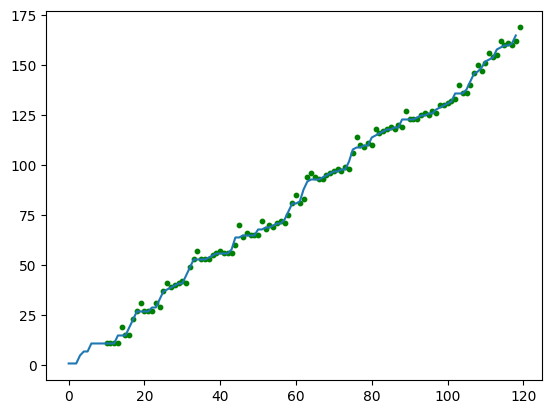

In [87]:
additional_x_values = np.arange(10, 120)

plt.plot(np.cumsum(test_runs))
plt.scatter(additional_x_values, predsum, s=10,c='g')

plt.show()

In [ ]:
def new_inp(x, out):
    """
    This function creates a new input sequence by adding the outcome of the next ball to the end of the input sequence.
    
    Args:
        x: A numpy array containing the input features.
        out: The outcome of the next ball.
        
    Returns:
        A new numpy array containing the input features with the outcome of the next ball added.
    """
    new_x = x.copy()  # Create a copy of the input features
    
    new_x[0][-1] = out  # Add the outcome of the next ball to the end of the input sequence
    return new_x


In [86]:
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

In [185]:
df_team1 = df2[df2['batting_team_idx'] == 0]
sequences = create_sequences(df_team1, 10)
target_variables = []
for sequence in sequences:  # Function to create sequences of length max_len
    target_variables.append(get_target_variable(sequence)) 

padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', value=-1)
padded_sequences
X_train = []
y_train = []
outcome_index = -1  # Assuming outcome is the last element in each sequence
for sequence in sequences:
    # Extract features (excluding outcome)
    # features = [element for element in sequence[:-1] if element != sequence[outcome_index]]  # List comprehension for selective exclusion
    # X_train.append(sequence[:-1][:,:-1])
    X_train.append(sequence[:,:-1])
    
    # Extract target variable (outcome)
    target = sequence[-1][outcome_index]
    y_train.append(target)
X_train = np.array(X_train)
y_train = np.array(y_train)
n_train_time = int(0.8 * X_train.shape[0])
X_train ,X_test = X_train[:n_train_time], X_train[n_train_time:]
print(X_train.shape, X_test.shape)
y_train, y_test = y_train[:n_train_time], y_train[n_train_time:]
y_train1= (pd.get_dummies(pd.DataFrame(y_train, columns=['outcome'])['outcome'],prefix= 'outcome',dtype= int).values)
y_test1= (pd.get_dummies(pd.DataFrame(y_test, columns=['outcome'])['outcome'],prefix= 'outcome',dtype= int).values) 



(3111, 10, 9) (778, 10, 9)


In [152]:
y_test1.shape

(778, 7)

Epoch 1/100


/Users/rahul/miniconda3/envs/btp/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


389/389 - 4s - 10ms/step - accuracy: 0.3815 - loss: 1.5960 - val_accuracy: 0.4023 - val_loss: 1.5408
Epoch 2/100
389/389 - 2s - 5ms/step - accuracy: 0.4008 - loss: 1.5494 - val_accuracy: 0.4139 - val_loss: 1.5313
Epoch 3/100
389/389 - 2s - 5ms/step - accuracy: 0.4079 - loss: 1.5389 - val_accuracy: 0.4010 - val_loss: 1.5263
Epoch 4/100
389/389 - 2s - 5ms/step - accuracy: 0.4188 - loss: 1.5298 - val_accuracy: 0.3997 - val_loss: 1.5348
Epoch 5/100
389/389 - 2s - 5ms/step - accuracy: 0.4131 - loss: 1.5232 - val_accuracy: 0.4075 - val_loss: 1.5327
Epoch 6/100
389/389 - 2s - 5ms/step - accuracy: 0.4221 - loss: 1.5207 - val_accuracy: 0.4126 - val_loss: 1.5226
Epoch 7/100
389/389 - 2s - 5ms/step - accuracy: 0.4201 - loss: 1.5186 - val_accuracy: 0.3985 - val_loss: 1.5229
Epoch 8/100
389/389 - 2s - 5ms/step - accuracy: 0.4262 - loss: 1.5154 - val_accuracy: 0.4126 - val_loss: 1.5273
Epoch 9/100
389/389 - 2s - 5ms/step - accuracy: 0.4198 - loss: 1.5093 - val_accuracy: 0.4036 - val_loss: 1.5280
Epo

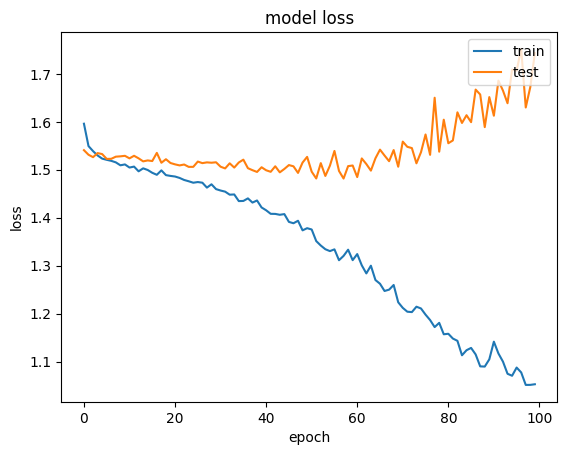

In [186]:
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))

#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
# model.add(LSTM(units=32))
# model.add(Dropout(0.2))

# model.add(Dense(1, activation='sigmoid'))
model.add(Dense(7, activation='softmax'))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
optimizer = Adam(learning_rate=0.01)  # Replace 0.001 with your desired learning rate

# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# fit network
history = model.fit(X_train, y_train1, epochs=100, batch_size=8, validation_data=(X_test, y_test1), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [ ]:
#DROP OUTCOME =5 remember important

In [87]:
yhat = model.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, yhat))

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean squared error: 3.97


In [34]:
df1['bowler'].value_counts()

bowler
Broad         192
Dernbach      144
Malinga       135
Shakib        132
Razzak        132
             ... 
Waller          6
Woakes          6
Ziaur           6
Sajedul         6
du Plessis      2
Name: count, Length: 143, dtype: int64

In [6]:
match_info

{'Stadium Name': 'Trent Bridge, Nottingham',
 'Toss Winner': 'West Indies',
 'First Innings': 'West Indies',
 'Second Innings': 'England',
 'First Innings runs': '172',
 'Second Innings runs': '173',
 'First Innings Wickets': '4',
 'Second Innings Wickets': '3',
 'Winner': 'England'}